In [1]:
# General Imports
import numpy as np
from math import pi
import datetime
# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Pandas Imports
import pandas as pd

#Seaborn Imports
from seaborn import heatmap

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.algorithms.classifiers import VQC

from IPython.display import clear_output

In [2]:
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

In [3]:
def support_vector_machine(hd, feature_list, kernel, random_state = 0):
    sample_train, sample_test, label_train, label_test = train_test_split(hd[feature_list],
                                                                          hd['target'],test_size=0.3,
                                                                          random_state=random_state,
                                                                          stratify=hd['target'])
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Scale
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Select
    train_size = len(sample_train)

    label_train = label_train[:train_size].to_numpy(copy="True")

    test_size = len(sample_test)
    sample_test = sample_test[:test_size]
    label_test = label_test[:test_size].to_numpy(copy="True")

    output_svc = SVC(kernel=kernel)
    output_svc.fit(sample_train, label_train)

    return output_svc, sample_test, label_test

In [4]:
def show_metrics(data, feature_list, kernel, random_state, show_AUC = False):
    print("random state", random_state)
    print(feature_list)
    print()
    svc_output , sample_test, y_true = support_vector_machine(data, feature_list, kernel,
                                                                 random_state = random_state)
    y_pred = svc_output.predict(sample_test)
    print(classification_report(y_true, y_pred))
    if show_AUC:
        y_score = svc_output.decision_function(sample_test)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(label =\
         r"ROC (AUC = %0.3f )" % roc_auc_score(y_true, y_score) )
    return

In [56]:
def show_aucs(data, feature_list, kernel_dic, random_state):
        
    suptitle = "ROC curve for "+str(len(feature_list))+"-feature dataset"
    title = "\n(Positive Label: Coronary Artery Disease - Random State:"\
            + str(random_state) +')'
    
    plt.figure(0).clf()    
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0,1], [0,1], 'k--')
    plt.suptitle(suptitle)
    plt.title(title, fontsize = 10)
    
    for k_name, kernel in kernel_dic.items():
        
        svc_output , sample_test, y_true = support_vector_machine(data, feature_list, kernel,
                                                                  random_state = random_state)
        y_pred = svc_output.predict(sample_test)
        y_score = svc_output.decision_function(sample_test)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr,tpr,
                 label= k_name+" AUC = %0.2f" % auc)
    plt.legend(loc=0)    
    plt.show()
    return

In [5]:
prime_list = []
nb_prime = 0
for num in range(2,1000):
    prime = True
    for i in range(2,num):
        if (num%i==0):
            prime = False
    if prime:
        prime_list.append(num)
        nb_prime += 1
    if nb_prime == 100:
        break
print(len(prime_list))   

100


In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
heart_data = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

In [7]:
heart_data = heart_data.rename(columns={'resting bp s': 'rs'}) # turnaround for blanks

# taking care of impossible 0.0 values: mean substitution
mean_trestbps = heart_data.query("rs != 0.0")['rs'].mean()
heart_data.loc[heart_data["rs"] == 0.0, "rs"] = mean_trestbps

mean_cholesterol = heart_data.query("cholesterol != 0.0")['cholesterol'].mean()
heart_data.loc[heart_data["cholesterol"] == 0.0, "cholesterol"] = mean_cholesterol

heart_data = heart_data.rename(columns={'rs': 'resting bp s'})

In [8]:
heart_data.describe()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
count,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000,1190.000
mean,53.720,0.764,3.233,132.265,245.907,0.213,0.698,139.733,0.387,0.923,1.624,0.529
std,9.358,0.425,0.935,17.964,52.942,0.410,0.870,25.518,0.487,1.086,0.610,0.499
min,28.000,0.000,1.000,80.000,85.000,0.000,0.000,60.000,0.000,-2.600,0.000,0.000
25%,47.000,1.000,3.000,120.000,214.000,0.000,0.000,121.000,0.000,0.000,1.000,0.000
50%,54.000,1.000,4.000,130.000,245.907,0.000,0.000,140.500,0.000,0.600,2.000,1.000
75%,60.000,1.000,4.000,140.000,269.750,0.000,2.000,160.000,1.000,1.600,2.000,1.000
max,77.000,1.000,4.000,200.000,603.000,1.000,2.000,202.000,1.000,6.200,3.000,1.000


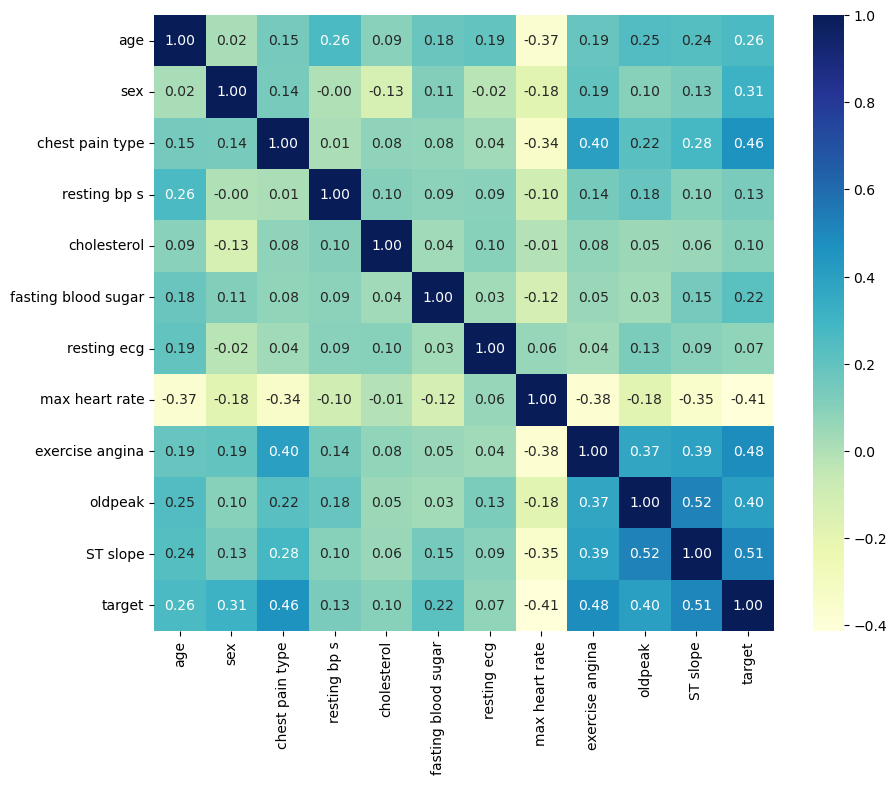

In [9]:
fig, ax = plt.subplots(figsize = (10,8))
ax = heatmap(heart_data.corr(),
                annot = True,
                fmt = ".2f",
                cmap = 'YlGnBu')

##  4-qubit feature map for 11 features

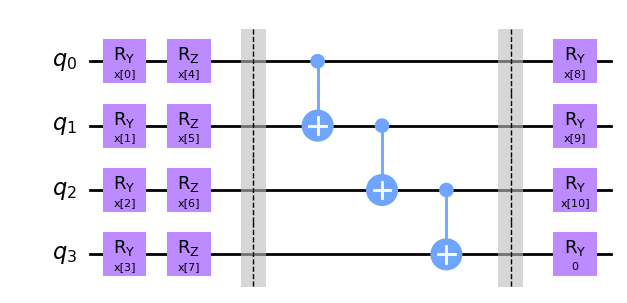

In [10]:
p1 = ParameterVector('x', 11)  
feature_map = QuantumCircuit(4)
for i in range(4):
    feature_map.ry(p1[i],i)
for i in range(4):
    feature_map.rz(p1[i+4],i)
feature_map.barrier()
for i in range(3):
    feature_map.cx(i,i+1)
feature_map.barrier()
for i in range(3):
    feature_map.ry(p1[i+8],i)
feature_map.ry(0,3)
feature_map.draw(output="mpl")

In [11]:
zz_kernel = QuantumKernel(feature_map=feature_map, quantum_instance=Aer.get_backend('statevector_simulator'))

## 11-qubit feature map for 11 features

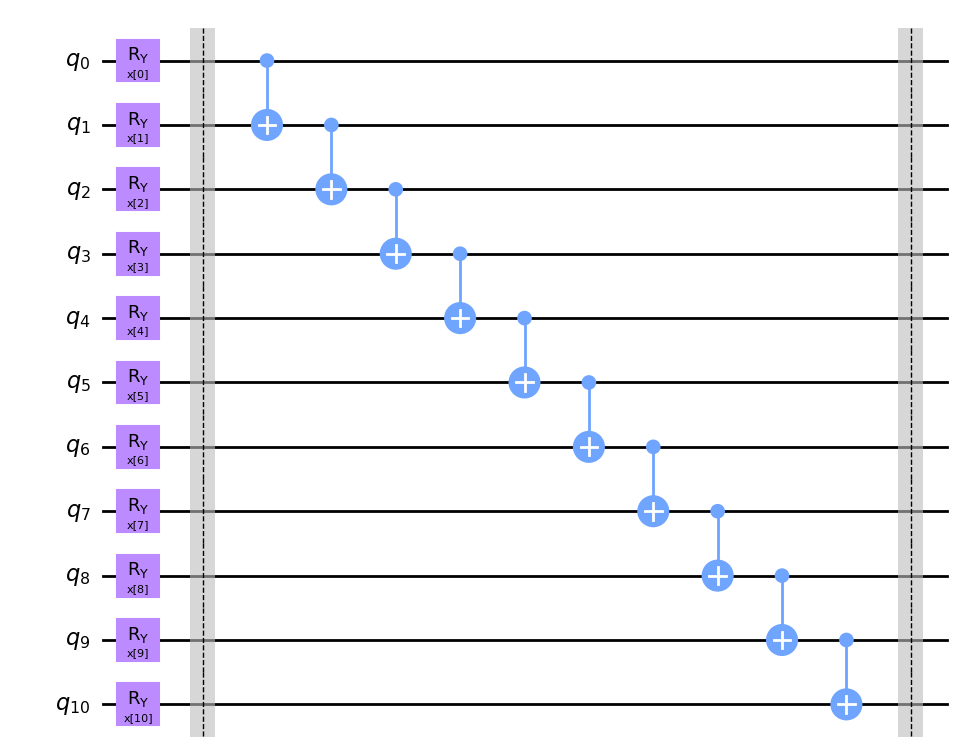

In [12]:
p1 = ParameterVector('x', 11)  
feature_map_11q = QuantumCircuit(11)
for i in range(11):
    feature_map_11q.ry(p1[i],i)
feature_map_11q.barrier()
for i in range(10):
    feature_map_11q.cx(i,i+1)
feature_map_11q.barrier()
feature_map_11q.draw(output="mpl")

In [13]:
zz_kernel_11q = QuantumKernel(feature_map=feature_map_11q, quantum_instance=Aer.get_backend('statevector_simulator'))

### Finding random state corresponding to mean accuracy value

In [14]:
# for accuracy as score, not used here
def compute_accuracy(df, feature_list, kernel, random_state):
        output_svc, sample_test, label_test = support_vector_machine(df,
                                                                     feature_list,
                                                                     kernel,
                                                                     random_state)
        return accuracy_score(label_test, output_svc.predict(sample_test))  

In [15]:
feature_list =  ['age', 'sex', 'chest pain type','resting bp s','cholesterol','fasting blood sugar',
                 'resting ecg','max heart rate','exercise angina', 'oldpeak', 'ST slope']       

In [66]:
only_once = False
if only_once:
    nb_row = len(prime_list)
    np_auc = np.zeros([nb_row, 3], dtype=float)

    for i, random_state in enumerate(prime_list):
        print(random_state, datetime.datetime.now().strftime("%H:%M:%S"))
        for j, kernel in enumerate(["linear",
                                   zz_kernel.evaluate,
                                   zz_kernel_11q.evaluate]):

            svc_output , sample_test, y_true = support_vector_machine(
                                                    heart_data,
                                                    feature_list,
                                                    kernel,
                                                    random_state)
            y_pred = svc_output.predict(sample_test)
            y_score = svc_output.decision_function(sample_test)
            np_auc[i][j] = roc_auc_score(y_true, y_score)
        print(np_auc[i])
    
    columns_values = ['classical','svm_q4','svm_q11']
    index_values = list(range(nb_row))
    acc_df = pd.DataFrame(data = np_auc, index = index_values,
                      columns = columns_values)
    acc_df.to_csv('prime_ieee_11q_acc.csv', index=False)

else:
    acc_df = pd.read_csv('prime_ieee_11q_acc.csv')
    np_auc = acc_df.to_numpy(dtype=float)

In [67]:
acc_df.describe()    

,classical,svm_q4,svm_q11
count,100.000,100.000,100.000
mean,0.902,0.894,0.907
std,0.015,0.017,0.015
min,0.865,0.850,0.872
25%,0.890,0.883,0.897
50%,0.902,0.892,0.908
75%,0.913,0.908,0.917
max,0.932,0.932,0.941


In [68]:
from scipy.stats import ttest_rel
print(ttest_rel(acc_df.classical, acc_df.svm_q4))
print(ttest_rel(acc_df.classical, acc_df.svm_q11))
print(ttest_rel(acc_df.svm_q4, acc_df.svm_q11))

Ttest_relResult(statistic=9.314983624649956, pvalue=3.4145116563092524e-15)
Ttest_relResult(statistic=-7.250211442363838, pvalue=9.32034355121718e-11)
Ttest_relResult(statistic=-16.960209646427604, pvalue=4.759453886626861e-31)


In [69]:
from scipy.stats import linregress
res = linregress(acc_df.svm_q11, acc_df.svm_q4)
print(res)
print(f"R-squared: {res.rvalue**2:.6f}")
res4 = linregress(acc_df.classical, acc_df.svm_q4)
print(res4)
print(f"R-squared: {res4.rvalue**2:.6f}")
res11 = linregress(acc_df.classical, acc_df.svm_q11)
print(res11)
print(f"R-squared: {res11.rvalue**2:.6f}")

LinregressResult(slope=0.9796543044794951, intercept=0.0047649646665298695, rvalue=0.8743779569013324, pvalue=1.5361029606512603e-32, stderr=0.0549189370638689, intercept_stderr=0.04983934391971125)
R-squared: 0.764537
LinregressResult(slope=0.9703536325120509, intercept=0.018554789631135438, rvalue=0.8495221898469698, pvalue=5.707599836524883e-29, stderr=0.060870697068571684, intercept_stderr=0.05490473642842999)
R-squared: 0.721688
LinregressResult(slope=0.8832540538853627, intercept=0.11080403129893135, rvalue=0.8663711486815677, pvalue=2.5947635726909283e-31, stderr=0.051430144440517245, intercept_stderr=0.04638945602679201)
R-squared: 0.750599


## A look at 11-qubit solution

In [37]:
# use the random state nearest to cross validation aucs
auc_classical = 0.897
auc_svm_q4 = 0.880
auc_svm_q11 = 0.941
# we are more interested in comparing classical and svm_q11
dist_array = ( np_auc[:,0]-auc_classical )**2\
             + ( np_auc[:,2]- auc_svm_q11 )**2
index_r = dist_array.argmin()
random_state = prime_list[index_r]
print("random_state for auc nearest to cross validation values:", random_state)
print("classical auc :", np_auc[:,0][index_r])
print("svm q4 auc    :", np_auc[:,1][index_r]) 
print("svm q11 auc   :", np_auc[:,2][index_r])                

random_state for auc nearest to cross validation values: 257
classical auc : 0.9071869488536156
svm q4 auc    : 0.92123330813807
svm q11 auc   : 0.9283824640967498


In [38]:
# use random_state for auc nearest to the mean intersection
dist_array = ( np_auc[:,0]-np.mean(np_auc[:,0]) )**2\
             + ( np_auc[:,2]-np.mean(np_auc[:,2]) )**2
index_r11 = dist_array.argmin()
random_state_11 = prime_list[index_r11]
print("random_state for auc nearest to the mean intersection:", random_state_11)
print("classical auc :", np_auc[:,0][index_r11])
print("     qsvm auc :", np_auc[:,2][index_r11])     

random_state for auc nearest to the mean intersection: 233
classical auc : 0.9017384731670446
     qsvm auc : 0.9081317712270092


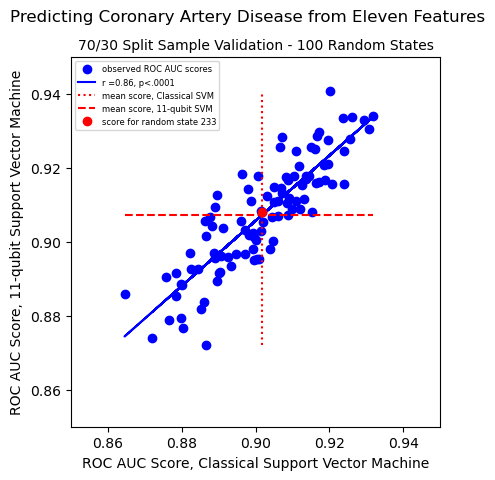

In [71]:
x = acc_df.classical
y = acc_df.svm_q11
plt.plot(x, y, 'ob', label='observed ROC AUC scores')
plt.suptitle("Predicting Coronary Artery Disease from Eleven Features" )
plt.title("70/30 Split Sample Validation - 100 Random States",
          fontsize = 10) 
plt.xlabel("ROC AUC Score, Classical Support Vector Machine")
plt.ylabel("ROC AUC Score, 11-qubit Support Vector Machine")
plt.plot(x, res11.intercept + res11.slope*x, 'b',
         label='r ='+str(res11.rvalue)[:4]+", p<.0001"  )
plt.vlines( np.mean(x), np.min(y), np.max(y), 'r',
           linestyles='dotted', label = 'mean score, Classical SVM')
plt.hlines( np.mean(y), np.min(x), np.max(x), 'r',
           linestyles='dashed', label = 'mean score, 11-qubit SVM')
plt.plot(np_auc[:,0][index_r11], np_auc[:,2][index_r11],
         'or', label = "score for random state " + str(random_state_11) )
plt.legend(loc=2, prop={'size': 6})
plt.xlim(0.85, .95)
plt.ylim(0.85, 0.95)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

## A look at 4-qubit solution

In [40]:
# use the random state nearest to cross validation aucs

# we are now interested in comparing classical and svm_q4
dist_array = ( np_auc[:,0]-auc_classical )**2\
             + ( np_auc[:,1]- auc_svm_q4 )**2
index_r = dist_array.argmin()
random_state = prime_list[index_r]
print("random_state for auc nearest to cross validation values:", random_state)
print("classical auc :", np_auc[:,0][index_r])
print("svm q4 auc    :", np_auc[:,1][index_r]) 
print("svm q11 auc   :", np_auc[:,2][index_r])                

random_state for auc nearest to cross validation values: 13
classical auc : 0.8992189468379945
svm q4 auc    : 0.880228017132779
svm q11 auc   : 0.8981796422272612


In [41]:
# use random_state for auc nearest to the mean intersection
dist_array = ( np_auc[:,0]-np.mean(np_auc[:,0]) )**2\
             + ( np_auc[:,1]-np.mean(np_auc[:,1]) )**2
index_r4 = dist_array.argmin()
random_state_4 = prime_list[index_r4]
print("random_state for auc nearest to the mean intersection:", random_state_4)
print("classical auc :", np_auc[:,0][index_r4])
print("     qsvm auc :", np_auc[:,1][index_r4])     

random_state for auc nearest to the mean intersection: 79
classical auc : 0.9007621567145376
     qsvm auc : 0.8923847316704459


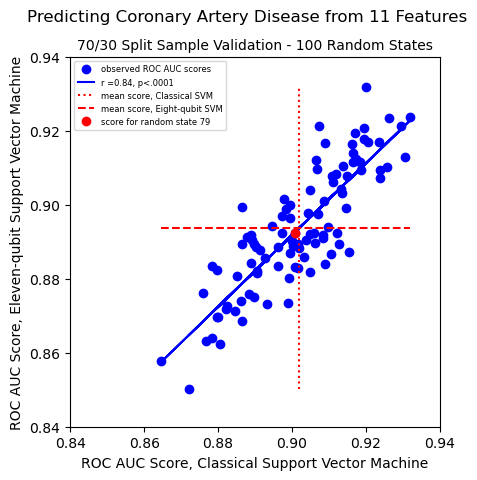

In [72]:
x = acc_df.classical
y = acc_df.svm_q4
plt.plot(x, y, 'ob', label='observed ROC AUC scores')
plt.suptitle("Predicting Coronary Artery Disease from 11 Features" )
plt.title("70/30 Split Sample Validation - 100 Random States",
          fontsize = 10) 
plt.xlabel("ROC AUC Score, Classical Support Vector Machine")
plt.ylabel("ROC AUC Score, Eleven-qubit Support Vector Machine")
plt.plot(x, res4.intercept + res4.slope*x, 'b',
         label='r ='+str(res4.rvalue)[:4]+", p<.0001"  )
plt.vlines( np.mean(x), np.min(y), np.max(y), 'r',
           linestyles='dotted', label = 'mean score, Classical SVM')
plt.hlines( np.mean(y), np.min(x), np.max(x), 'r',
           linestyles='dashed', label = 'mean score, Eight-qubit SVM')
plt.plot(np_auc[:,0][index_r4], np_auc[:,1][index_r4],
         'or', label = "score for random state " + str(random_state_4) )
plt.legend(loc=2, prop={'size': 6})
plt.xlim(0.84, .94)
plt.ylim(0.84, 0.94)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

## Metrics: random state from 11-qubit solution

In [46]:
kernel_dic = {"ROC Classical SVM:" : "linear",
              "ROC 4-qubit SVM  :" : zz_kernel.evaluate,
              "ROC 11-qubit SVM:" : zz_kernel_11q.evaluate}

In [44]:
for k_name, kernel in kernel_dic.items():
    print(k_name, "random state:", random_state_11)
    show_metrics(heart_data, feature_list, kernel, random_state_11)

ROC Classical SVM: random state: 233
random state 233
['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       168
           1       0.81      0.85      0.83       189

    accuracy                           0.82       357
   macro avg       0.82      0.81      0.81       357
weighted avg       0.82      0.82      0.81       357

ROC 4-qubit SVM  : random state: 233
random state 233
['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       168
           1       0.81      0.87      0.84       189

    accuracy                           0.82       357
   macro avg       

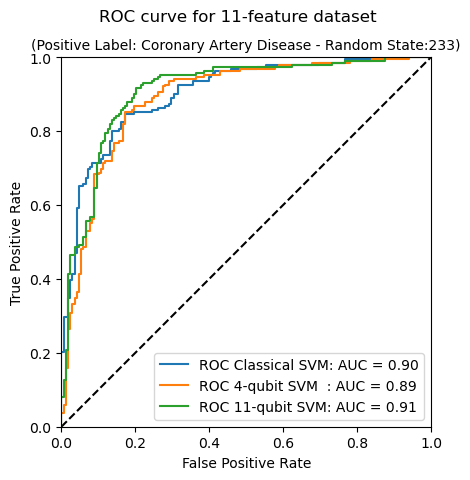

In [57]:
show_aucs(heart_data, feature_list, kernel_dic, random_state_11)  

## Metrics: random state from 4-qubit solution

In [51]:
for k_name, kernel in kernel_dic.items():
    print(k_name, "random state:", random_state_4)
    show_metrics(heart_data, feature_list, kernel, random_state_4)

ROC Classical SVM: random state: 79
random state 79
['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']

              precision    recall  f1-score   support

           0       0.88      0.77      0.83       168
           1       0.82      0.91      0.86       189

    accuracy                           0.85       357
   macro avg       0.85      0.84      0.84       357
weighted avg       0.85      0.85      0.84       357

ROC 4-qubit SVM  : random state: 79
random state 79
['age', 'sex', 'chest pain type', 'resting bp s', 'cholesterol', 'fasting blood sugar', 'resting ecg', 'max heart rate', 'exercise angina', 'oldpeak', 'ST slope']

              precision    recall  f1-score   support

           0       0.89      0.79      0.84       168
           1       0.83      0.92      0.87       189

    accuracy                           0.86       357
   macro avg       0.86

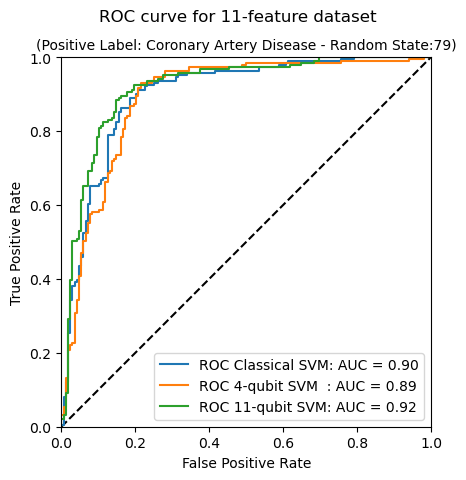

In [58]:
show_aucs(heart_data, feature_list, kernel_dic, random_state_4)  

## Metrics: common  random state for 4 and 11 qubits

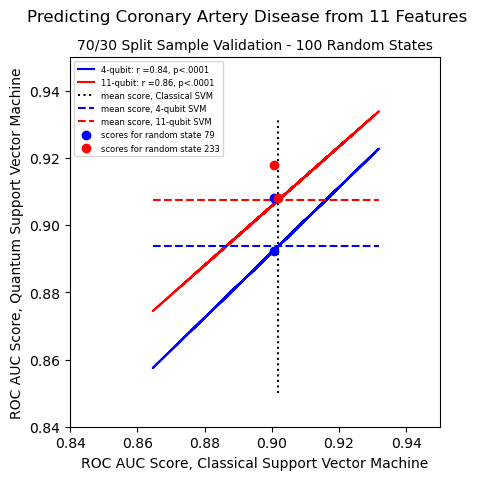

In [76]:
# find appropriate random state
x = acc_df.classical
y = acc_df.svm_q4
y11 = acc_df.svm_q11
#plt.plot(x, y, 'xb', label='4-qubit')
#plt.plot(x, y11, 'xr, label='11_qubit')
plt.suptitle("Predicting Coronary Artery Disease from 11 Features" )
plt.title("70/30 Split Sample Validation - 100 Random States",
          fontsize = 10) 
plt.xlabel("ROC AUC Score, Classical Support Vector Machine")
plt.ylabel("ROC AUC Score, Quantum Support Vector Machine")
plt.plot(x, res4.intercept + res4.slope*x, 'b',
         label='4-qubit: r ='+str(res4.rvalue)[:4]+", p<.0001"  )
plt.plot(x, res11.intercept + res11.slope*x, 'r',
         label='11-qubit: r ='+str(res11.rvalue)[:4]+", p<.0001"  )
plt.vlines( np.mean(x), np.min(y), np.max(y), 'black',
           linestyles='dotted', label = 'mean score, Classical SVM')
plt.hlines( np.mean(y), np.min(x), np.max(x), 'b',
           linestyles='dashed', label = 'mean score, 4-qubit SVM')
plt.hlines( np.mean(y11), np.min(x), np.max(x), 'r',
           linestyles='dashed', label = 'mean score, 11-qubit SVM')

plt.plot(np_auc[:,0][index_r4], np_auc[:,1][index_r4],
         'ob', label = "scores for random state " + str(random_state_4) )
plt.plot(np_auc[:,0][index_r4], np_auc[:,2][index_r11], 'ob')
plt.plot(np_auc[:,0][index_r11], np_auc[:,2][index_r11],
         'or', label = "scores for random state " + str(random_state_11) )
plt.plot(np_auc[:,0][index_r4], np_auc[:,2][index_r4], 'or')
plt.legend(loc=2, prop={'size': 6})
plt.xlim(0.84, .95)
plt.ylim(0.84, 0.95)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

In [60]:
# 79 was tested just before! No need to run the following code
# random_state_ok = 79 
#for k_name, kernel in kernel_dic.items():
    #print(k_name, "random state:", random_state_ok)
    #show_metrics(heart_data, feature_list, kernel, random_state_ok)

# show_aucs(heart_data, feature_list, kernel_dic, random_state_ok)  